In [84]:
import os
import numpy as np
from random import randint
import matplotlib.pyplot as plt

from simple_nn import Network

np.seterr(all='raise')

try:
    from notify import notify
except ImportError:
    def notify(*msgs, **kwargs):
        print ' '.join([str(m) for m in msgs])
        
EPSILLON = 1e-10

In [85]:
def flatten(input_value):
    return input_value.reshape(input_value.shape[0], -1)

def normalize(input_value):
    res = input_value - np.min(input_value)
    return res / np.max(res)

def image_preprocess(image_data):
    return normalize(flatten(image_data))

In [86]:
# Loading dataset
import torchvision
root = os.path.expanduser("./datasets/mnist")
train_dataset = torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=True)
test_dataset = torchvision.datasets.MNIST(root, train=False, transform=None, target_transform=None, download=True)

x_train = np.array(train_dataset.train_data, dtype=np.float)
x_test = np.array(test_dataset.test_data, dtype=np.float)
y_train = np.array(train_dataset.train_labels, dtype=np.int)
y_test  = np.array(test_dataset.test_labels, dtype=np.int)

x_train shape: (60000, 28, 28)
x_train shape: (10000, 28, 28)


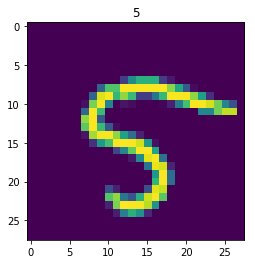

In [87]:
%matplotlib inline

# Show details about the dataset
print 'x_train shape:', x_train.shape
print 'x_train shape:', x_test.shape

i = randint(0, x_train.shape[0]-1)
plt.imshow(x_train[i, ...])
plt.title(y_train[i])
plt.show()

In [88]:
def to_categorical(y_data):
    l = np.max(y_data) - np.min(y_data) + 1
    res = np.zeros((y_data.shape[0], l))
    for i in range(y_data.shape[0]):
        res[i, y_data[i]] = 1
    return res

In [89]:
x_train_processed = image_preprocess(x_train)#[:100, :]
x_test_processed = image_preprocess(x_test)#[:100, :]

y_train_processed = to_categorical(y_train)#[:100, :]
y_test_processed = to_categorical(y_test)#[:100, :]

print 'x_train', x_train.shape
print 'x_train_processed', x_train_processed.shape
print ''
print 'y_train', y_train.shape
print 'y_train_processed', y_train_processed.shape

x_train (60000, 28, 28)
x_train_processed (60000, 784)

y_train (60000,)
y_train_processed (60000, 10)


In [90]:
def check_acc(dataset_x, dataset_y):
    m = dataset_y.shape[0]
    
    y_hat_test = nn.predict(dataset_x.T)

    error = np.zeros(m)
    for i in range(m):
        error[i] = np.argmax(y_hat_test[:, i]) == np.argmax(dataset_y.T[:, i])
    return np.sum(error) / len(error)

In [91]:
from abc import abstractmethod


def flatten(input_value):
    return input_value.reshape(input_value.shape[0], -1)

def normalize(input_value):
    res = input_value - np.min(input_value)
    return res / np.max(res)

def image_preprocess(image_data):
    return normalize(flatten(image_data))

# TODO: fix abstraction
class ActivationFunction:    
    @abstractmethod
    def activate(self, x):
        pass

    @abstractmethod
    def derivative(self, x):
        pass
    
    def __call__(self, x):
        return self.activate(x)

    
# And here some sample activation functions
class Sigmoid(ActivationFunction):
    def activate(self, x):
        '''
        Numerically stable sigmoid function. instead of: 
            return 1.0 / (1.0 + np.exp(-x))"
        '''
        try:
            x = np.clip(x, -30, +30)
            return np.where(x >= 0, 
                    1. / (1. + np.exp(-x)), 
                    np.exp(x) / (1. + np.exp(x)))
        except:
            print 'mean', np.mean(x)
            print 'mmx ', np.min(x), '~>', np.max(x)
            raise

    def derivative(self, x):
        return self.activate(x) * (1. - self.activate(x)) 

    
class ReLU(ActivationFunction):
    def activate(self, x):
        return x * (x > 0)

    def derivative(self, x):
        return 1.0 * (x > 0)
    

class LeakyReLU(ActivationFunction):
    def activate(self, x):
        return np.where(x > 0, x, 0.01*x)

    def derivative(self, x):
        return np.where(x > 0, 1, 0.01)
    

class tanh(ActivationFunction):
    def activate(self, x):
        return np.tanh(x)

    def derivative(self, x):
        return 1.0 / np.cosh(x) ** 2


ACTIVATION_FUNCTIONS = {
    'sigmoid': Sigmoid(),
    'relu': ReLU(),
    'tanh': tanh(),
    'leakyrelu': LeakyReLU(),
}

def get_activation_function(actv_func):
    if isinstance(actv_func, str):
        if actv_func not in ACTIVATION_FUNCTIONS:
            raise Exception('activation "%s" not found' % actv_func)
        actv_func = ACTIVATION_FUNCTIONS[actv_func]
    return actv_func

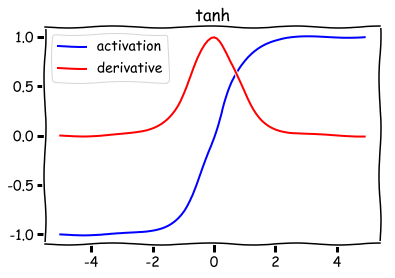

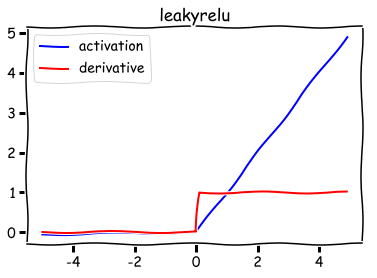

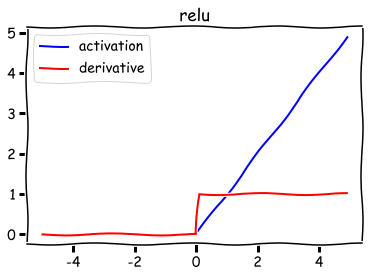

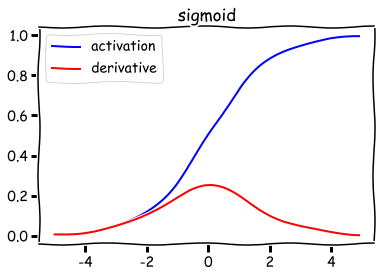

In [92]:
%matplotlib inline

# List Activation Functions
with plt.xkcd():
    x = np.array(list(range(-50, +50))) / 10.0
    for name, func in ACTIVATION_FUNCTIONS.items():
        plt.plot(x, func(x), 'b', label='activation')
        plt.plot(x, func.derivative(x), 'r', label='derivative')
        plt.title(name)
        plt.legend()
        plt.show()

In [93]:
NEURON_CLIP = 900.

class Layer:
    def __init__(self, n, prev_n, **kwargs):
        self.actv_func_name = kwargs.get('activation', 'sigmoid')
        self.actv_func = get_activation_function(self.actv_func_name)
        
        self.normalized = kwargs.get('normalized', False)
        self.keep_prob = kwargs.get('keep_prob', None)
        
        self.n = n
        self.prev_n = prev_n
        self.initialize()
        
    def initialize(self):
        # FIXME: fix here
        if self.actv_func_name in ['relu', 'leakyrelu']:
            self.w = np.random.normal(loc=0.5, scale=0.1, size=(self.n, self.prev_n))
            self.b = np.random.normal(loc=0.5, scale=0.1, size=(self.n, 1))
        else:
            self.w = np.random.normal(loc=0, scale=0.1, size=(self.n, self.prev_n))
            self.b = np.random.normal(loc=0, scale=0.1, size=(self.n, 1))

        # These parameters will be used in backprop
        self.x0 = 0
        self.z0 = 0
        self.dw = 0
        self.db = 0
        self.moment_dw = 0
        self.moment_db = 0
        
        # normalization
        self.mu = 0
        self.var = 1
        self.beta = 0
        self.gamma = 1
        
        # Debug plot
        self.random_weight_selector = np.random.random(self.w.shape) < (10./(self.w.shape[0]*self.w.shape[1]))
        self.random_bias_selector = np.random.random(self.b.shape) < (10./self.b.shape[0])
        self.hist_w = []
        self.hist_b = []
    
    def set_params(self, new_w, new_b, new_func=None):
        if new_w.shape != self.w.shape:
            raise Exception('weight size mismatch. Expecting %s but got %s' % (self.w.shape, new_w.shape))
        if new_b.shape != self.b.shape:
            raise Exception('bias size mismatch. Expecting %s but got %s' % (self.b.shape, new_b.shape))
            
        self.w = new_w
        self.b = new_b
        if new_func is not None:
            self.actv_func = get_activation_function(new_func)
    
    
    def normalize(self, vec, set_value=False):
        if set_value:
            EXP_AVG_COEFF = 0.7
            self.mu = self.mu * EXP_AVG_COEFF + np.mean(vec, axis=1) * (1-EXP_AVG_COEFF)
            self.var = self.var * EXP_AVG_COEFF + np.var(vec, axis=1) * (1-EXP_AVG_COEFF)
        
        norm = (vec.T - self.mu) / np.sqrt(self.var + EPSILLON)
        return norm.T
    
    def batchnorm_backward(self, error):
        X, X_norm, mu, var, gamma, beta = cache

        N, D = X.shape

        X_mu = X - self.mu
        std_inv = 1. / np.sqrt(self.var + EPSILLON)

        dX_norm = dout * self.gamma
        dvar = np.sum(dX_norm * X_mu, axis=0) * -.5 * std_inv**3
        dmu = np.sum(dX_norm * -std_inv, axis=0) + dvar * np.mean(-2. * X_mu, axis=0)

        dX = (dX_norm * std_inv) + (dvar * 2 * X_mu / N) + (dmu / N)
        dgamma = np.sum(error * X_norm, axis=0)
        dbeta = np.sum(error, axis=0)

        return dX, dgamma, dbeta
    
    def forward(self, x, is_in_backprop):
        z = self.w.dot(x) + self.b
        z = np.clip(z, -NEURON_CLIP, +NEURON_CLIP)
        if self.normalized:
            z = self.normalize(z, is_in_backprop) * self.gamma + self.beta
            
        a = self.actv_func(z)
        
        self.z0 = z
        self.x0 = x
        
        return a
    
    def backward(self, error, reg_lambda, m):
        delta = error * self.actv_func.derivative(self.z0)
        self.dw = delta.dot(self.x0.T) / float(m) - reg_lambda * self.w / float(m)
        self.db = delta.dot(np.ones((m,1))) / float(m) - reg_lambda * self.b / float(m)
        return self.w.T.dot(delta)
    
    def optimize_weights(self, eta, momentom=0.8):
        self.moment_dw = self.moment_dw * momentom + self.dw * (1-momentom)
        self.moment_db = self.moment_db * momentom + self.db * (1-momentom)
        
        self.w += eta * self.moment_dw
        self.b += eta * self.moment_db
        
        self.hist_w.append(self.w[self.random_weight_selector].flatten())
        self.hist_b.append(self.b[self.random_bias_selector].flatten())
        

In [94]:
class Network:
    def __init__(self, input_size):
        self.layers = []
        self.last_layer_size = input_size
        self.lr = 0.01
        self.regularization_lambda = 0.01
        self.initialize()
    
    def add_layer(self, n, activation='sigmoid', **kwargs):
        self.layers.append(Layer(
            n,
            self.last_layer_size,
            activation=activation,
            **kwargs
        ))
        self.last_layer_size = n
    
    def predict(self, x0, is_in_backprop=False):
        z = x0
        for l in self.layers:
            z = l.forward(z, is_in_backprop)
        return z
    
    def backpropagate(self, x0, y0):
        m = x0.shape[1]
        y_hat = self.predict(x0, True)
        error = self.loss_function(y0, y_hat)

        for i in reversed(range(len(self.layers))):
            error = self.layers[i].backward(error, self.regularization_lambda, m)
        
        for i in range(len(self.layers)):
            self.layers[i].optimize_weights(self.lr)

    def initialize(self):
        self.train_loss_history = []
        self.test_loss_history = []
        for l in self.layers:
            l.initialize()
    
    def loss_function(self, y0, y_hat):
        regularization_term = self.regularization_lambda * sum([
#             np.sum(np.square(l.w)) + np.sum(np.square(l.b)) for l in self.layers
            np.sum(np.square(l.w)) for l in self.layers
        ]) / (2. * y0.shape[1])
        
        if y0.shape[0] == 1:
            return (y0-y_hat) + regularization_term
        else:
            return y0*np.log(y_hat+EPSILLON) + (1-y0)*np.log(1-y_hat+EPSILLON) + regularization_term
    
    def train(self, x, y, epochs, **kwargs):
        if kwargs.get('initialize', False):
            self.initialize()
            
        if 'test_data' in kwargs:
            x_test = kwargs['test_data'][0]
            y_test = kwargs['test_data'][1]
            test_data = True
        else:
            test_data = False
            
        self.lr = kwargs.get('lr', self.lr)
        batch_size = kwargs.get('batch_size', 32)
        
        for e in range(epochs):
            i = 0; print_counter = 0
            train_batch_loss = []
            while(i<x.shape[1]):
                x_batch = x[:, i:i+batch_size]
                y_batch = y[:, i:i+batch_size]
                i += batch_size
                print_counter += 1
                
                self.backpropagate(x_batch, y_batch)
                train_batch_loss.append(np.linalg.norm(self.loss_function(self.predict(x_batch), y_batch)))

            loss =  np.mean(train_batch_loss)
            self.train_loss_history.append(loss)
            
            # calculate the test acc
            if test_data:
                i=0
                test_batch_loss = []
                while(i<x_test.shape[1]):
                    x_batch = x_test[:, i:i+batch_size]
                    y_batch = y_test[:, i:i+batch_size]
                    i += batch_size
                    test_batch_loss.append(np.linalg.norm(self.loss_function(self.predict(x_batch), y_batch)))
                self.test_loss_history.append(np.mean(test_batch_loss))


            if np.isnan(loss):
                raise Exception('loss is NaN')

                
            if kwargs.get('verbose', True) and (epochs <= 10 or e % int(epochs/10) == 0):
                if kwargs.get('visualize_progress', False):
                    self.plot_loss()
                print 'epoch: %d/%d - loss=%.2f' % (e+1, epochs, loss)
                
                # TODO: remove this
                for i in range(len(self.layers)):
                    c = self.layers[i].dw.shape
#                     print '     dw%d:' % i, np.sum(self.layers[i].dw) / (c[0] * c[1])
#                     print '      w%d:' % i, np.sum(self.layers[i].w) / (c[0] * c[1])
#                     print ''
            
            
    def plot_loss(self):
        with plt.xkcd():
            plt.plot(self.train_loss_history, label='train')
            if len(self.test_loss_history) > 0:
                plt.plot(self.test_loss_history, 'r--', label='test')
                plt.legend()
            plt.title('loss')
            plt.show()

            for i, l in enumerate(self.layers):
                plt.plot(l.hist_w)
                plt.title('W%d' % (i+1))
                plt.show()

                plt.plot(l.hist_b)
                plt.title('B%d' % (i+1))
                plt.show()

In [95]:
# creating the dataset
def xor(x, y):
    return 1 if x+y != 1 else 0

xor_x_train_aug = []
xor_y_train_aug = []

for _ in range(1024):
    a = randint(0, 1)
    b = randint(0, 1)
    xor_x_train_aug.append([a, b])
    xor_y_train_aug.append([xor(a, b)])

xor_x_train_aug = np.array(xor_x_train_aug)
xor_y_train_aug = np.array(xor_y_train_aug)

xor_x_train_test = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1],
])

xor_y_train_test = np.array([xor(i[0], i[1]) for i in xor_x_train_test])

In [96]:
def plot_prediction():
    M = xor_x_train_aug.shape[0]
    xx = xor_x_train_aug[:, 0] + xor_x_train_aug[:, 1] * 2
    xx = np.reshape(xx, (M, 1)).transpose()

    y_hat = nn.predict(xor_x_train_aug.T)

    with plt.xkcd():
        plt.plot(xx.T, xor_y_train_aug, '*', label='truth')
        plt.plot(xx.T, y_hat.T, 'ro', label='predicted')
        plt.legend()
        plt.show()

    for x_i, y_i in zip(xor_x_train_test, xor_y_train_test):
        a = nn.predict(np.reshape(x_i, (2, 1)))
        r = 1 * (a > 0.5)
        print x_i, '~~>', '%d (=%.2f)' % (r, a), '[%d]' % y_i

epoch: 1/10 - loss=376.20
epoch: 2/10 - loss=376.20
epoch: 3/10 - loss=376.20
epoch: 4/10 - loss=376.20
epoch: 5/10 - loss=376.20
epoch: 6/10 - loss=376.20
epoch: 7/10 - loss=376.20
epoch: 8/10 - loss=376.20
epoch: 9/10 - loss=376.20
epoch: 10/10 - loss=376.20


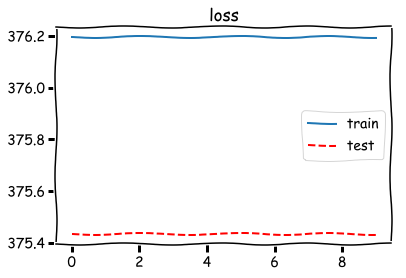

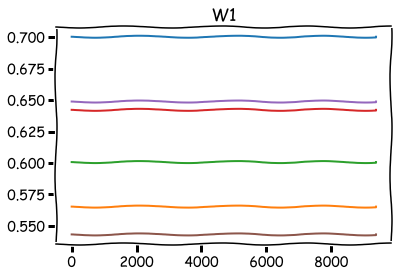

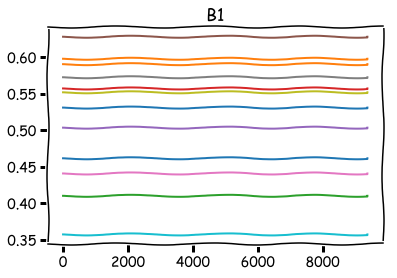

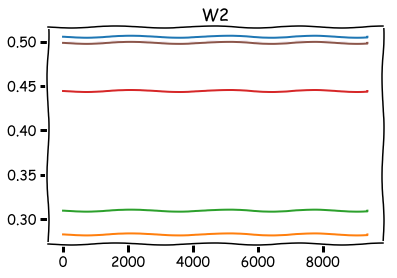

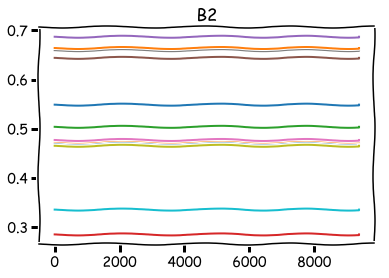

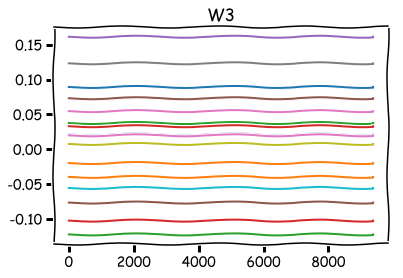

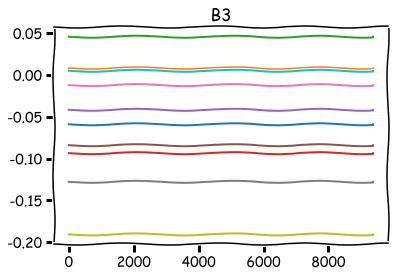

test acc: 11.35%
train acc: 11.24%


In [99]:
nn = Network(input_size=x_train_processed.shape[1])
nn.add_layer(1024, 'relu')
nn.add_layer(1024, 'relu')
nn.add_layer(10)

nn.regularization_lambda = 0

nn.train(
    x_train_processed.T,
    y_train_processed.T,
    epochs=10,
    batch_size=64,
#     visualize_progress=True,
    test_data=(x_test_processed.T, y_test_processed.T),
    lr=.01
)
nn.plot_loss()
print 'test acc: %.2f%%' % (check_acc(x_test_processed, y_test_processed) * 100)
print 'train acc: %.2f%%' % (check_acc(x_train_processed, y_train_processed) * 100)

--------------------------------------

In the next assignment we try to implement CNN and solve Fashion-MNIST problem with it. Please follow up with this [link](https://github.com/ArefMq/simple-nn/blob/master/Day-5.ipynb).